### Objective: 
In this notebook, I am trying to figure out how to do the following stuff. 

1. Compute the correlation between the different electrodes for each signal. 
2. Determine how to compute the periodgram for each. 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from os.path import join,dirname, split
from numpy import linalg as la
from os import listdir
from scipy.io import loadmat
from GraphingSetup import configure_plots, create_tableau_colors
%matplotlib inline
configure_plots()
tableau = create_tableau_colors()
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib.mlab import psd
sns.set_style('white')
sns.set_context('talk')

In [2]:
def load_data(path,convert_index=False):
    """converts the data to a pandas object
    Parameters: 
        path(str): absolute path to the m file 
        convert_index(bool): if True, convert the index to a time delta
    Returns: 
        (data,sampling_rate,sequence):(pd.DataFrame, int, int) 
    """
    # load the matlab file and extract the data
    data = loadmat(path)['dataStruct']
    
    # get the sampling rate and cast to int
    sampling_rate = int(data['iEEGsamplingRate'][0][0])
    
    #extract the iEEG traces and electrode channel data and place into a data frame
    traces = data['data'][0][0]
    channels = data['channelIndices'][0][0][0]
    df = pd.DataFrame(traces, columns = channels)
    
    if convert_index: 
        df.index = convert_index_to_timedelta(df.index, sampling_rate)
    
    #get the sequence collection number if present (not present in test)
    sequence = -1
    if 'sequence' in data.dtype.names:
        sequence =int(data['sequence'])

    return df, sampling_rate, sequence

In [3]:
base = '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG'
train1_path = join(base, 'train_1')
train2_path = join(base, 'train_2')
train3_path = join(base, 'train_3')

def get_files():
    """gets the file names"""
    base = '/Users/crivera5/Documents/NonIntuitProjects/Kaggle/KaggleEEG'
    path1 = join(base, 'train_1')
    path2 = join(base, 'train_2')
    path3 = join(base, 'train_3')

    def get_fs(path):
        return [join(path, f) for f in listdir(path) if f.endswith('.mat')]

    return get_fs(path1) + get_fs(path2) + get_fs(path3)


In [4]:
filenames = get_files()

In [5]:
data =load_data(filenames[0], convert_index =False)
ts = data[0]
sampling_rate  = data[1]

### Extract the correlation
Below, I just do the correlation between the signals. 

In [6]:
def extract_correlations(data):
    """Calculate the correlation matrix for time series with its associated eigenvalues and the eigenvalues
    Parameters:
        data(pd.DataFrame): Data frame with the time series data
    Returns:
        corr(pd.Series): The correlations the time series
        eigs(pd.Series): The eigenvalues.

    """

    def format_tuple(t):
        """Helper function to arrange tuples."""
        # convet to list and sort
        t = sorted(list(t))
        return 'corr(%d,%d)' % (t[0], t[1])

    # calculate the correlation matrix and its eigenvalues
    corr = data.corr()
    eigs = pd.Series(la.eigvals(corr))

    # manipulate the corr data
    corr.values[np.tril_indices_from(corr)] = np.nan
    corr = corr.unstack()
    corr = corr[corr.isnull() == False]

    # rename the indexes for the correlation
    corr.index = map(format_tuple, corr.index.tolist())

    # change the name of the eigs
    eigs.index = map(lambda x: 'eig_%d' % (x + 1), list(eigs.index))

    return pd.DataFrame(pd.concat([corr, eigs])).T



In [7]:
corr = extract_correlations(ts)
corr

,"corr(1,2)","corr(1,3)","corr(2,3)","corr(1,4)","corr(2,4)","corr(3,4)","corr(1,5)","corr(2,5)","corr(3,5)","corr(4,5)",...,eig_7,eig_8,eig_9,eig_10,eig_11,eig_12,eig_13,eig_14,eig_15,eig_16
0,0.413663,0.254337,0.311173,0.011521,-0.038443,0.116131,-0.070827,-0.10736,-0.098991,-0.063343,...,0.001385,0.813147,0.750338,0.710522,0.172071,0.571452,0.490635,0.298783,0.416663,0.379067


### Now do some of the frequency analysis

I'll have to read more into this, but lets get started!

When the input a is a time-domain signal and A = fft(a), np.abs(A) is its amplitude spectrum and np.abs(A)**2 is its power spectrum. The phase spectrum is obtained by np.angle(A).

In [8]:
# the fourier 
A = np.fft.rfft(ts[1],)
amplitude = np.abs(A)
power = np.abs(A)**2

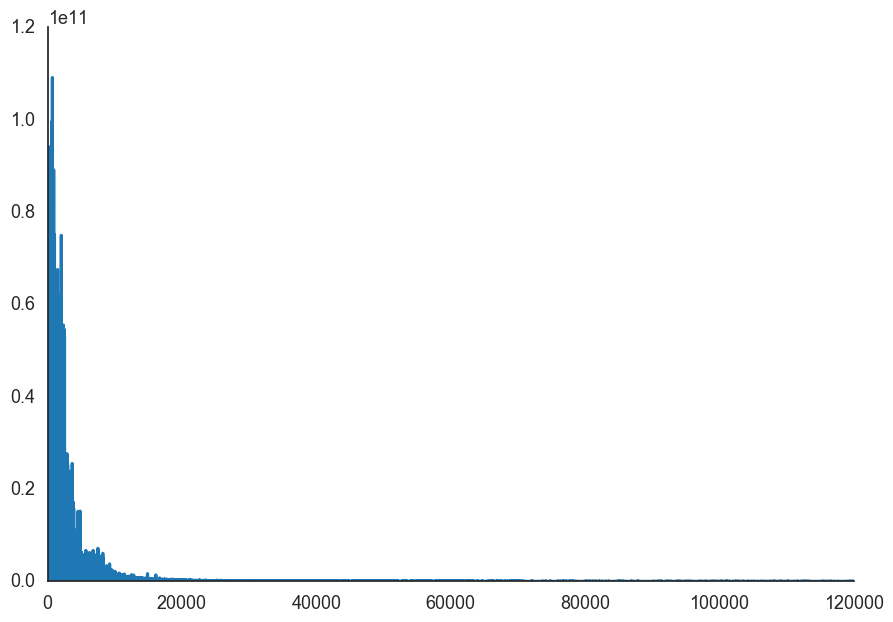

In [9]:
plt.plot(power)

### calculate a periodiogram

Below, I am calculationg the periodgram using scipy.signal psd function. This function computes the absolute value of the fft. Its nice because it takes care of the sampling frequency. 

In [10]:
# compute the signal for the first. 
x = ts[1]-ts[1].mean()
freqs, p=signal.periodogram(x, fs = 400)

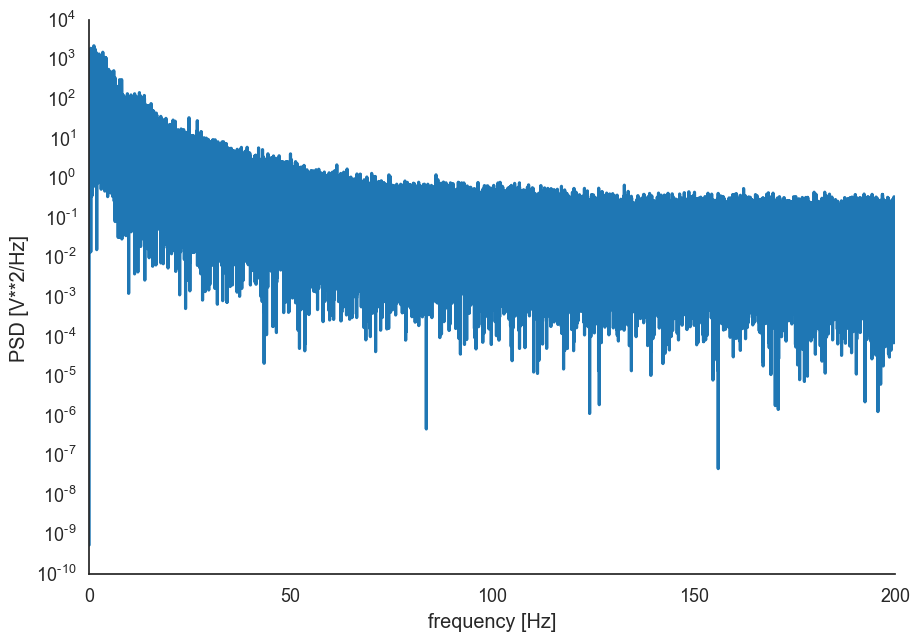

In [11]:
# plot the power spectrum on a semi-log axis
plt.semilogy(freqs,p)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')

### Write the tranform psd function
This calculates the psd. 
To solve for the psd. one uses the transform_psd which operates on the data. 
psd solves for one signal, transform psd sovles for the remainder. m

In [12]:
def psd(x, index=1):
    """ calculate the FFT periodiogram of time series x and returns as a df"""
    freqs, ppx = signal.periodogram(x, fs=400)
    name = 'PSD %d' %index

    return pd.DataFrame({name: ppx}, index=freqs, )


def transform_psd(data, detrend=True):
    """Generates the FFT powerspectrum using the scipy.signal periodiogram function with sampling rate of 400
    Parameters:
        data(pd.DataFrame): The data with the time series
        detrend(bool): if true, detrend with the mean
    Return:
        psd_df(pd.DataFrame): a data frame with the PSD
    """

    # copy the data
    data = data.copy()

    if detrend:
        data.apply(lambda x: x - x.mean())

    # calculate the psd
    return pd.concat([psd(data.iloc[:, i], i + 1) for i in range(16)], axis=1)


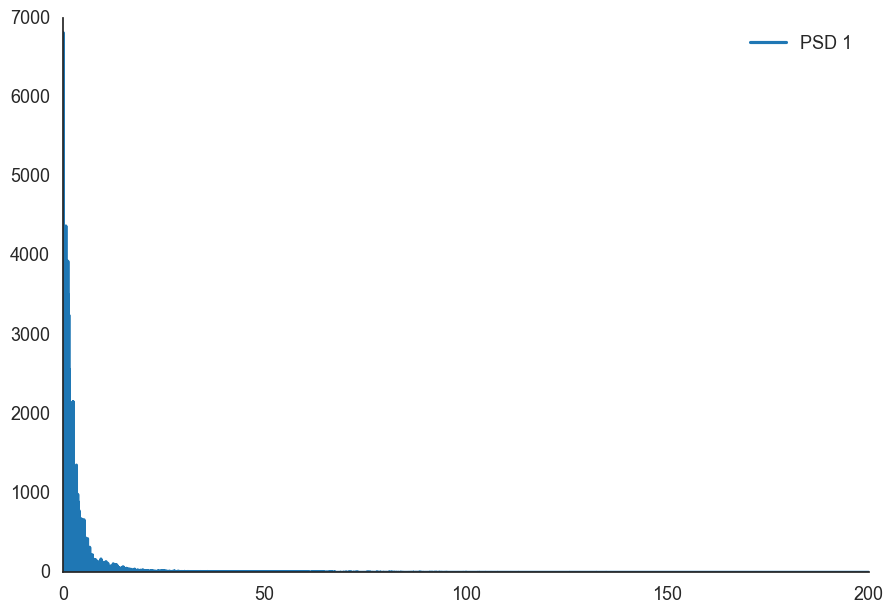

In [13]:
psd(ts.iloc[:,1]).plot()

In [14]:
psd_df =transform_psd(ts)

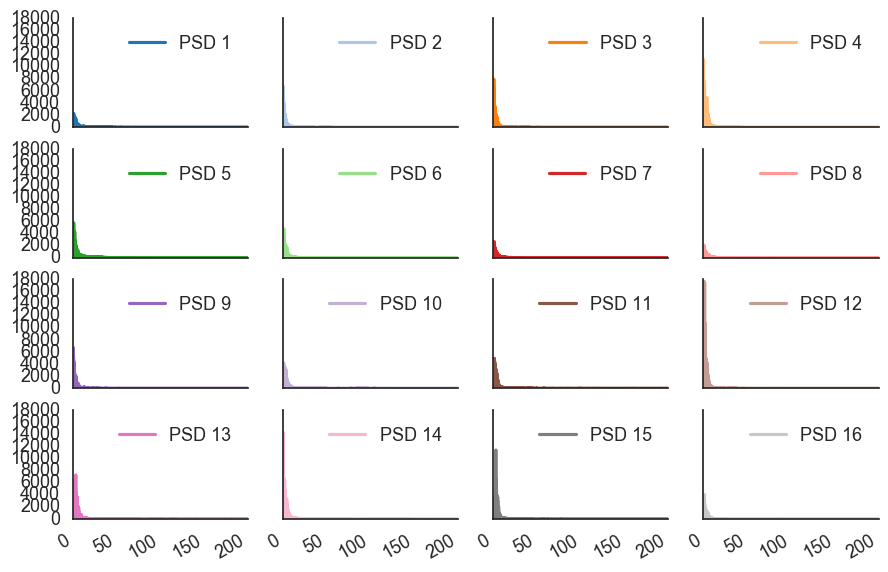

In [15]:
ax=psd_df.plot(subplots = True,layout = (4,4), sharey = True)

In [16]:
def extract_correlations(data,frequency_domain=False):
    """Calculate a correlation matrix with its associated eigenvalues and the eigenvalues. 
    Used for both caluculating frequency domain and non frequency domain. 
    Parameters:
        data(pd.DataFrame): Data frame with the time series data
    Returns:
        corr(pd.Series): The correlations the time series
        eigs(pd.Series): The eigenvalues.
        frequency_domain(bool): affects how the ouput data is labeled. If True, its in frequency space
    
    """

    def format_tuple(t,frequency):
        """Helper function to arrange tuples."""
        # convert to list and sort
        t = sorted(list(t))
        if frequency:
            return 'corr(%s,%s)' % (t[0], t[1])
        return 'corr(%d,%d)' % (t[0], t[1])

    # calculate the correlation matrix and its eigenvalues
    corr = data.corr()
    eigs = pd.Series(la.eigvals(corr))

    # manipulate the corr data
    corr.values[np.tril_indices_from(corr)] = np.nan
    corr = corr.unstack()
    corr = corr[corr.isnull() == False]

    # rename the indexes for the correlation
    corr.index = [format_tuple(index, frequency_domain) for index in corr.index.tolist()]

    # change the name of the eigs
    if frequency_domain:
        eigs.index = map(lambda x: 'PSD eig_%d' % (x + 1), list(eigs.index))
    else: 
        eigs.index = map(lambda x: 'eig_%d' % (x + 1), list(eigs.index))             
    return pd.DataFrame(pd.concat([corr, eigs])).T

In [17]:
s = extract_correlations(psd_df, True)

### PSI
A standard method is to compute the sum of the power spectra with bands
δ(0.5–4Hz), θ(4–7Hz), α(8–12Hz), β(12–30Hz), and γ(30–100Hz). Below is the function for this. 

It computes the Band Spectra sums on all of the features. 


In [109]:
def psi_rir(psd_series,index = 0):
    """Gets thePower Spectral Intensity of the standard bands for one time series
    This is using the standard bands of:
        δ(0.5–4Hz), θ(4–7Hz), α(8–12Hz), β(12–30Hz), and γ(30–100Hz)
    Parameters:
        psd_df(pd.DataFrame): a data frame with index frequencies and power.
        index(int): an index for labeling
    Returns:
        bands_df(pd.DataFrame): a data frame with the band sums
    """
    
    # compute the values for the psi and place into an array
    psis = np.array([psd_series[psd_series.between(0.5,4)].sum(),
                     psd_series[psd_series.between(4,7)].sum(),
                     psd_series[psd_series.between(8,12)].sum(),
                     psd_series[psd_series.between(12,30)].sum(),
                     psd_series[psd_series.between(30,70)].sum(),
                     psd_series[psd_series.between(70,180)].sum()
                    ])
    
    # compute the values for the rir
    rirs = psis/psis.sum()
                     
    # set up the data frame
    bands_df =pd.DataFrame({'channel %d δ(0.5–4Hz)'%(index+1): psis[0],                 
                            'channel %d θ(4–7Hz) '%(index+1): psis[1],
                            'channel %d α(8–12Hz)'%(index+1): psis[2],
                            'channel %d  β(12–30Hz)'%(index+1): psis[3],
                            'channel %d low γ(30–70Hz)'%(index+1): psis[4],
                            'channel %d high γ(70–180Hz)'%(index+1): psis[5],
                            'channel %d RIR1'%(index+1): rirs[0],
                            'channel %d RIR2'%(index+1): rirs[1],
                            'channel %d RIR3'%(index+1): rirs[2],
                            'channel %d RIR4'%(index+1): rirs[3],
                            'channel %d RIR5'%(index+1): rirs[4],
                            'channel %d RIR6'%(index+1): rirs[5]
                           },index = [1])
    
    return bands_df

def compute_psi_and_rir(psd_df):
    """computes the Power Spectral Intensity and the Relative Intenstiy Ratio of the standard bands for all time series.
    This is using the standard bands of: 
        δ(0.5–4Hz), θ(4–7Hz), α(8–12Hz), β(12–30Hz), and γ(30–100Hz)
    Parameters:
        psd_df(pd.DataFrame): a data frame with index frequencies and power.
    Returns:
        psi_rir_df(pd.DataFrame): a data frame with the band sums and the relative ratio
    """
    
    # create 
    psi_df = [psi_rir(psd_df.iloc[:,i],i) for i in range(16)]
    return pd.concat(psi_df,axis = 1)

In [110]:
bands=compute_psi_and_rir(psd_df).T

192

In [91]:
def petrosian_fd(ts):
    """ Computes the Fractal Dimension using one of Petrosians Methods. It is a simple yet inexact method for
    computing the fractal dimension. This algo uses method c) as per Esteller et al 2001.
    
    It estimates the fractal dimension as: 
    
    PFD =log10(N)/(log10(N) +log10(N/(N+0.4Ndelta)))
    where: N is the length of the series, (number of time points), Ndelta is the number of sign changes. 
    Parameters:
        ts(np.array or pd.Series): the array
    Returns: 
        pfd(float): the petrosian_fd
    """
    
    # get the number of total points
    n =len(ts)
    
    # compute the number of sign changes of the binary sequence
    # convert to binary sequence by subtracting the consecutive time points, 
    # and converting to +1 or 0 if postive or negative 
    binary = (ts.diff()>=0)+0 
    
    # compute the diff again to determine the transition points,and compute the N delta
    n_delta = np.sum(np.abs(binary.diff()))
    
    # compute and return the pfd
    return np.log10(n)/ (np.log10(n) + np.log10(n/(n+0.4*n_delta)))


def extract_petrosian_fd(time_series):
    """Computes the Petrosian Fractal Dimension for each time_series in a data frame
    Parameters:
        time_series(pd.DataFrame): the data frame with the time series
    Returns:
        pfd_df(pd.DataFrame): a row data frame with the PFD
    """
    
    # compute the values, place in a data frame and return
    pfd_df= pd.DataFrame(ts.apply(petrosian_fd))
    pfd_df.index = ['PFD %d'%i for i in range(len(d)) ]
    return pfd_df.T

### A class for FFT 



In [94]:
class FFT_Features(object):
    """ Class for extracting multiple features from a fft
        These features include:
            1. PowerSpectral Intensity
            2. Relative Intensity.
            3. Correlation of the PSD
            4. eigen values of the psd
            5. Spectral Entropy
            6. 
    """

    def __init__(self, data==None):
        if data:
            self.
        
        
        
        
